# Prediksi Harga Saham PT.Telkom dengan metode ARIMA

Pergerakan harga saham. 
- Open adalah harga pembukaan saham pada saat transaksi dimulai dalam suatu periode transaksi. Biasanya, harga pembukaan sama dengan harga penutupan transaksi hari sebelumnya.

- High menunjukkan harga tertinggi yang pernah terjadi dalam suatu periode perdagangan.

- Low menunjukkan harga terendah yang pernah terjadi dalam suatu periode perdagangan.

- Close menunjukkan harga penutupan suatu saham dalam satu hari perdagangan.

- Adj. Close adalah harga penutupan saham yang sudah disesuaikan (adjusted closing price)

# Load all the required libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('TLKM.JK.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-08,3400.0,3400.0,3310.0,3330.0,3212.497559,80636800
2021-09-09,3360.0,3390.0,3330.0,3390.0,3270.380371,82214400
2021-09-10,3380.0,3390.0,3320.0,3330.0,3212.497559,52115300
2021-09-13,3310.0,3350.0,3300.0,3350.0,3231.791748,45547200
2021-09-14,3380.0,3450.0,3350.0,3440.0,3318.616211,166002100
...,...,...,...,...,...,...
2022-09-02,4540.0,4620.0,4540.0,4600.0,4600.000000,106985000
2022-09-05,4560.0,4630.0,4550.0,4620.0,4620.000000,77323800
2022-09-06,4610.0,4620.0,4510.0,4510.0,4510.000000,61970100


# Visualize the per day closing price of the stock

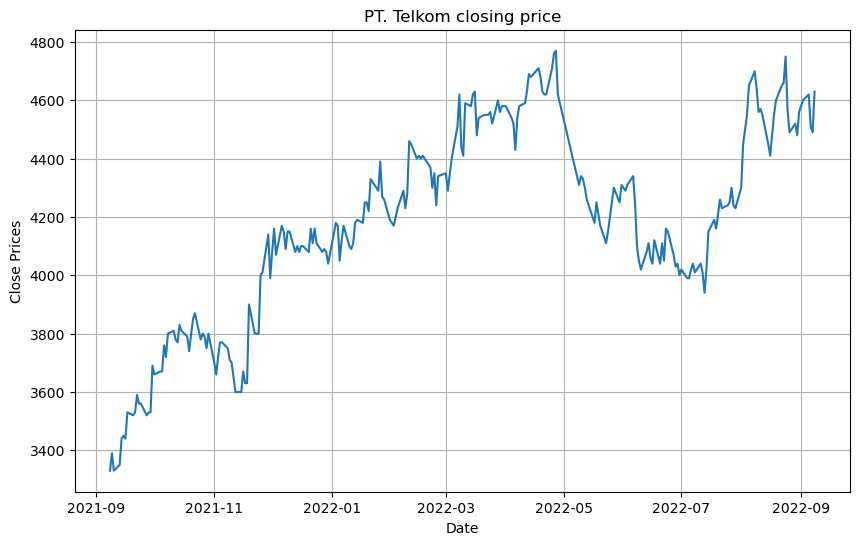

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('PT. Telkom closing price')
plt.show()

Visualisasi data dalam seri melalui distribusi probabilitas

<AxesSubplot:ylabel='Density'>

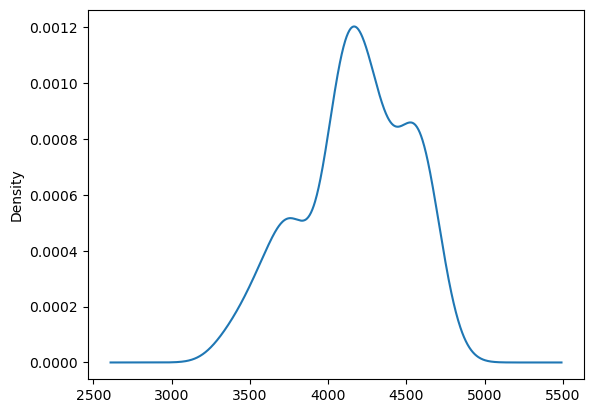

In [4]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

Juga, deret waktu tertentu diperkirakan terdiri dari tiga komponen sistematis termasuk level, tren, musiman, dan satu komponen non-sistematis yang disebut Noise.
Komponen-komponen ini didefinisikan sebagai berikut:
1. Level: Nilai rata-rata dalam seri.
2. Trend: Nilai naik atau turun dalam deret.
3. Musiman: Siklus jangka pendek yang berulang dalam seri.
4. Noise: Variasi acak dalam seri.

Pertama,kita perlu mengecek apakah data nya stationer atau tidak, karena time series analysis hanya bekerja jika datanya stasioner.

Tes ADF (Augmented Dickey-Fuller)

Tes Dickey-Fuller adalah salah satu tes statistik yang paling populer. Ini dapat digunakan untuk menentukan keberadaan akar satuan dalam deret, dan karenanya membantu kita memahami apakah deret itu stasioner atau tidak. Hipotesis nol dan alternatif dari tes ini adalah:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

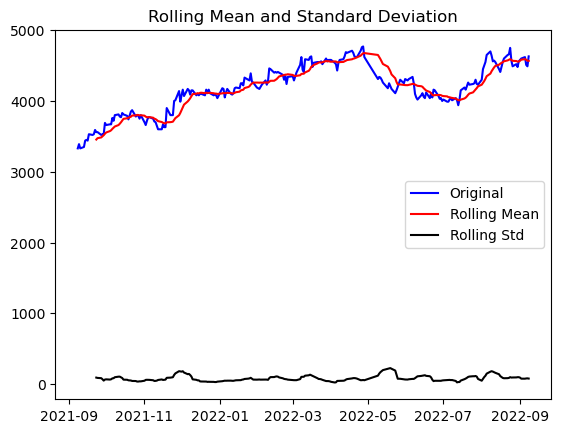

Results of dickey fuller test
Test Statistics                 -2.234115
p-value                          0.194097
No. of lags used                 2.000000
Number of observations used    243.000000
critical value (1%)             -3.457551
critical value (5%)             -2.873509
critical value (10%)            -2.573148
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

Diperoleh nilai p-value > 0,05, maka H0 tidak ditolak.

Jadi, data memiliki keadaan yang tidak stasioner.

Karena data belum stasioner, sehingga perlu dilakukan proses stasionerisasi data, yakni dengan proses differencing untuk memperoleh data yang stasioner.

<Figure size 640x480 with 0 Axes>

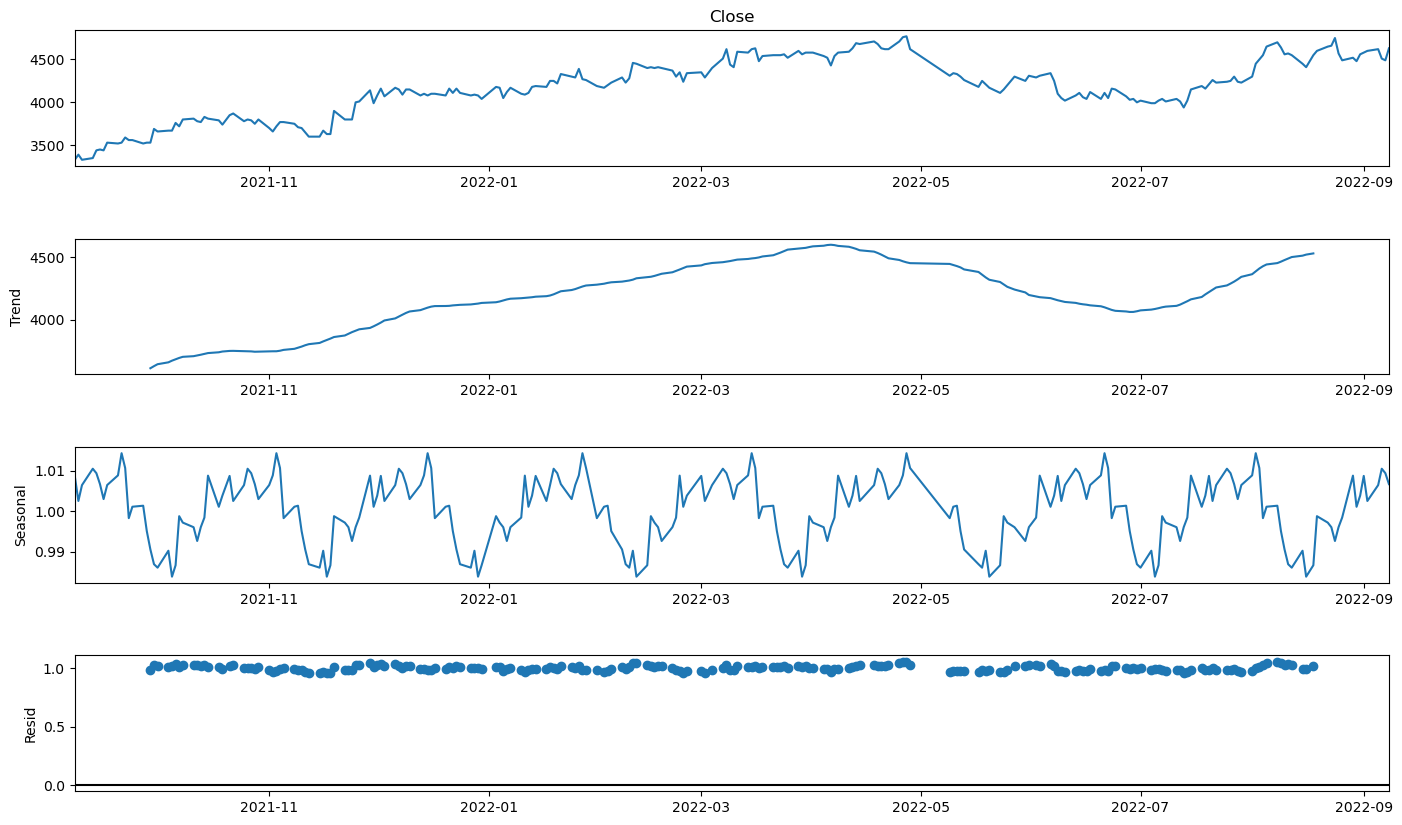

In [6]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


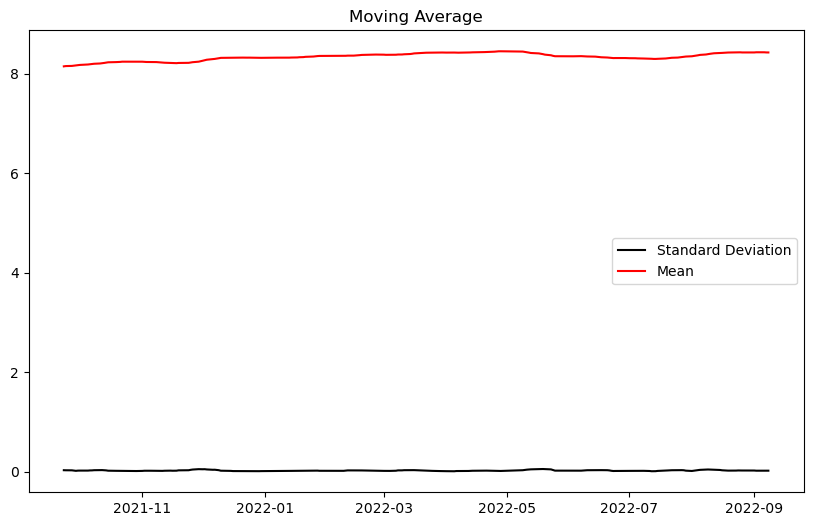

In [7]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

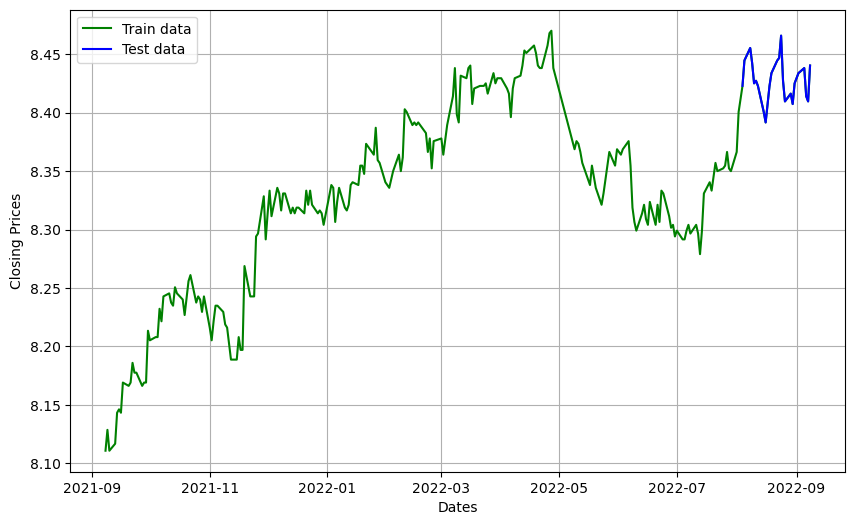

In [8]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1155.902, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1157.555, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1158.511, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1156.470, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1157.511, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1158.306, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1156.420, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1158.598, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1157.288, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1158.088, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1157.759, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1156.351, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.125 seconds
                               SARIMAX Results                              

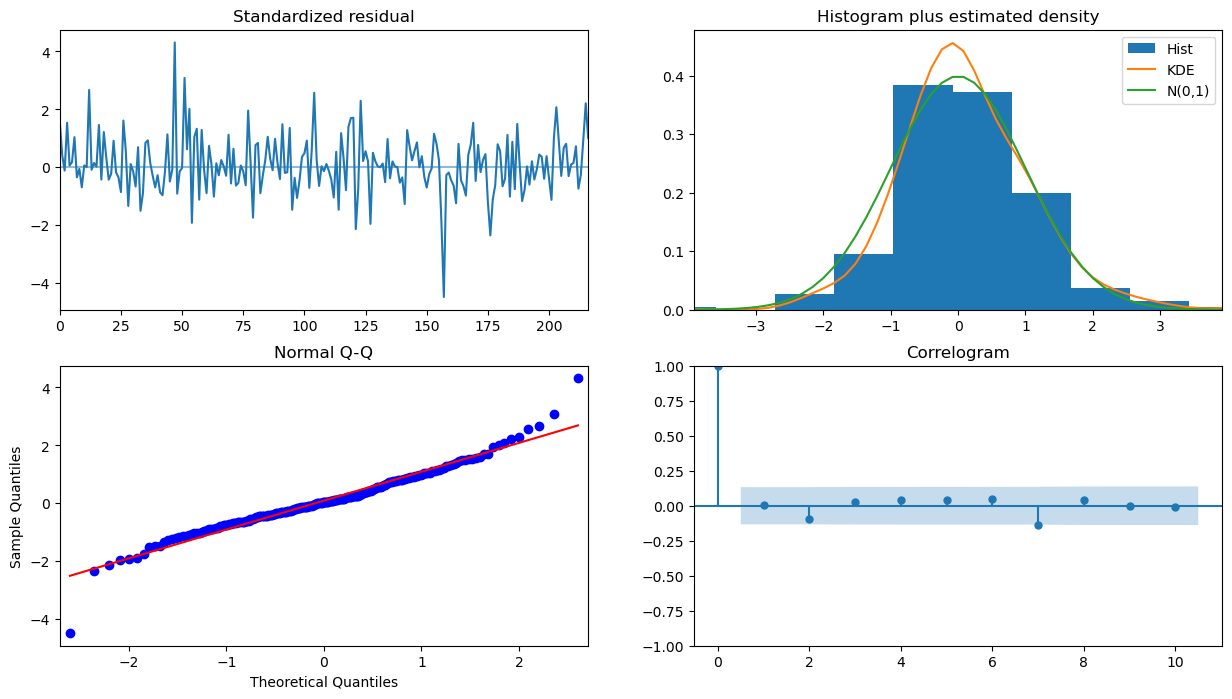

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

- Kiri atas: Kesalahan residual tampaknya berfluktuasi di sekitar rata-rata nol dan memiliki varians yang seragam.

- Kanan Atas: Plot kepadatan menunjukkan distribusi normal dengan rata-rata nol.

- Kiri bawah: Semua titik harus tepat sejajar dengan garis merah. Setiap penyimpangan yang signifikan akan menyiratkan distribusi miring.

- Kanan Bawah: Correlogram, alias, plot ACF menunjukkan kesalahan residual tidak autokorelasi. Setiap autokorelasi akan menyiratkan bahwa ada beberapa pola dalam kesalahan residual yang tidak dijelaskan dalam model. Jadi, Anda perlu mencari lebih banyak X (prediktor) pada model.

In [10]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  218
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 582.175
Date:                Sun, 18 Sep 2022   AIC                          -1156.351
Time:                        14:41:52   BIC                          -1142.831
Sample:                             0   HQIC                         -1150.889
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2470      0.734     -0.337      0.736      -1.685       1.191
ma.L1          0.1118      0.723      0.155      0.877      -1.306       1.530
ma.L2         -0.1195      0.101     -1.184      0.2

C:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [11]:
# Forecast
fc = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf
fc.index = test_data.index

C:\Users\Asus\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


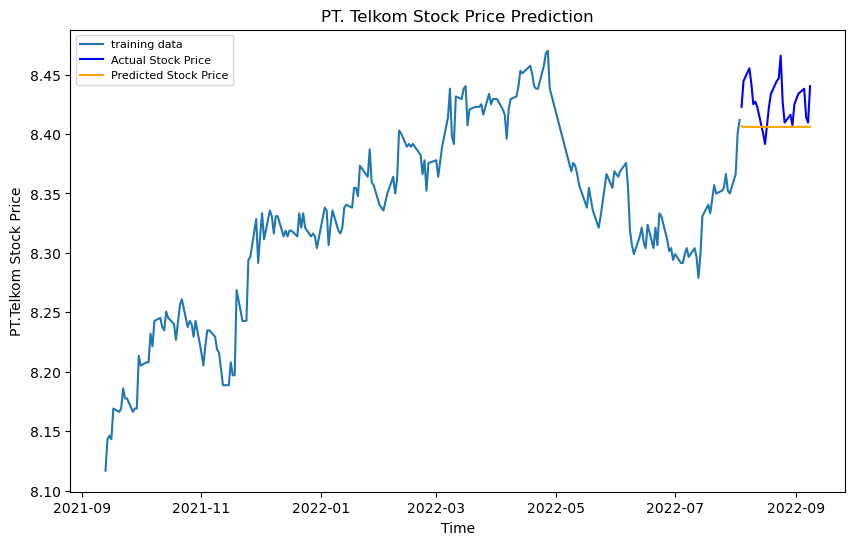

In [12]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('PT. Telkom Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PT.Telkom Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.000767277186232852
MAE: 0.02344419873478863
RMSE: 0.027699768703598446
MAPE: 0.0027784301139064343


Sekitar 0,2% MAPE menyiratkan bahwa model ini sekitar 99,8% akurat dalam memprediksi 15 pengamatan berikutnya